# Unit 3: Lesson 3: Project 4 Challenge:

## Logistic Regression, Ridge Regression, and Lasso Regression

### Objective: Predict Property Crime
Build a regression model to predict property crimes using New York crime data. Goal is to predict property crime rather than understand the mechanisms underlying the crime.  Will create a model that explains much of the variance.

Data source: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

Eva Rubin

November 2018

In [73]:
import numpy as np
import pandas as pd

import math
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import statsmodels.api as sm

# scipy: import cross validation and KFold
import scipy
from scipy import stats
from scipy.stats import boxcox

# sklearn: import cross validation and KFold
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# matplotlib and sns plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Help
# https://pythonfordatascience.org/linear-regression-python/

In [4]:
#plt.rcParams['figure.figsize'] = (50.0, 20.0)
#plt.rcParams.update({'font.size': 22})

In [5]:
# Grab and process the raw data.
data_path = ("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv"
            )
df_orig = pd.read_csv(data_path, delimiter= ',', header=None)

In [6]:
# Look at structure of df_orig
df_orig.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Table 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
5,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
6,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
7,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
8,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
9,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [7]:
# Get the number of rows and columns
df_orig.shape

(356, 13)

In [8]:
# Get column names
df_orig.dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
dtype: object

In [9]:
# Rename columns
df_orig.rename(columns={0: 'city', 1: 'pop_size', 2: 'violent_crime', 3: 'murder_manslaughter',
       4: 'rape_1', 5: 'rape_2', 6: 'robbery', 7: 'aggravated_assault', 8: 'property_crime', 
       9: 'burglary', 10: 'larceny_theft', 11: 'mv_theft', 12: 'arson_3'}, inplace=True)

df_orig.columns


Index(['city', 'pop_size', 'violent_crime', 'murder_manslaughter', 'rape_1',
       'rape_2', 'robbery', 'aggravated_assault', 'property_crime', 'burglary',
       'larceny_theft', 'mv_theft', 'arson_3'],
      dtype='object')

In [10]:
# Check for samples with null records for property crime since it is dependent variable
df_orig.loc[df_orig['property_crime'] == '0']

,city,pop_size,violent_crime,murder_manslaughter,rape_1,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
191,Manchester Village,"1,688",0,0,NaN,0,0,0,0,0,0,0,0
213,New Berlin Town,"1,622",0,0,NaN,0,0,0,0,0,0,0,0
261,Port Byron Village,"1,274",0,0,NaN,0,0,0,0,0,0,0,0
292,Schoharie Village,872,0,0,NaN,0,0,0,0,0,0,0,0
300,Shortsville Village,"1,437",0,0,NaN,0,0,0,0,0,0,0,0
324,Tuxedo Park Village,615,0,0,NaN,0,0,0,0,0,0,0,0


In [11]:
# Drop above samples from data set since all categories are 0 and they represent a small sample
# possible missing reports or just no crimes whatsoever in small towns?

df_orig = df_orig[df_orig['property_crime'] > '0']


In [12]:
# create new df copy and Remove rape_1 column and remove first 5 unwanted rows and last 3 unwanted rows.
df = df_orig.drop('rape_1', axis=1).drop(df_orig.index[0:5]).drop(df_orig.index[-3:]).copy()

In [13]:
df.head(10)


,city,pop_size,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3
9,Albion Village,"6,388",23,0,3,4,16,223,53,165,5,NaN
10,Alfred Village,"4,089",5,0,0,3,2,46,10,36,0,NaN
11,Allegany Village,"1,781",3,0,0,0,3,10,0,10,0,0
12,Amherst Town,"118,296",107,1,7,31,68,"2,118",204,"1,882",32,3
13,Amityville Village,"9,519",9,0,2,4,3,210,16,188,6,1
14,Amsterdam,"18,182",30,0,0,12,18,405,99,291,15,0
15,Arcade Village,"2,053",0,0,0,0,0,39,3,35,1,0
16,Ardsley Village,"4,523",5,0,0,3,2,33,4,28,1,0
17,Asharoken Village,658,0,0,0,0,0,2,0,2,0,0
18,Attica Village,"2,522",2,0,0,0,2,5,0,4,1,0


In [14]:
# Clean up features

# Remove commas in pop size numbers
df['pop_size'] = df['pop_size'].str.replace(',', '')

# Remove commas in numbers
df['property_crime'] = df['property_crime'].str.replace(',', '')

# Remove commas in numbers
df['robbery'] = df['robbery'].str.replace(',', '')

# Remove commas in numbers
df['violent_crime'] = df['violent_crime'].str.replace(',', '')

# Remove commas in numbers
df['rape_2'] = df['rape_2'].str.replace(',', '')

# Remove commas in numbers
df['aggravated_assault'] = df['aggravated_assault'].str.replace(',', '')

# Remove commas in numbers
df['burglary'] = df['burglary'].str.replace(',', '')

# Remove commas in numbers
df['larceny_theft'] = df['larceny_theft'].str.replace(',', '')

# Remove commas in numbers
df['mv_theft'] = df['mv_theft'].str.replace(',', '')


In [15]:
# Convert type to int (from string)

df['pop_size'] = df['pop_size'].astype(int)

df['property_crime'] = df['property_crime'].astype(int)

df['robbery'] = df['robbery'].astype(int)

df['violent_crime'] = df['violent_crime'].astype(int)

df['murder_manslaughter'] = df['murder_manslaughter'].astype(int)

df['rape_2'] = df['rape_2'].astype(int)

df['aggravated_assault'] = df['aggravated_assault'].astype(int)

df['burglary'] = df['burglary'].astype(int)

df['larceny_theft'] = df['larceny_theft'].astype(int)

df['mv_theft'] = df['mv_theft'].astype(int)

df['arson_3'] = df['mv_theft'].astype(int)


# Convert to str
df['city'] = df['city'].astype(str)


In [16]:
# Convert new features to catgorical: murder, robbery for possible later use

df['murder_manslaughter_cat'] = np.where(df['murder_manslaughter'] == 0, 0, 1)

df['robbery_cat'] = np.where(df['robbery'] == 0, 0, 1)


In [17]:
df.dtypes

city                       object
pop_size                    int64
violent_crime               int64
murder_manslaughter         int64
rape_2                      int64
robbery                     int64
aggravated_assault          int64
property_crime              int64
burglary                    int64
larceny_theft               int64
mv_theft                    int64
arson_3                     int64
murder_manslaughter_cat     int64
robbery_cat                 int64
dtype: object

In [18]:
df.head()

,city,pop_size,violent_crime,murder_manslaughter,rape_2,robbery,aggravated_assault,property_crime,burglary,larceny_theft,mv_theft,arson_3,murder_manslaughter_cat,robbery_cat
9,Albion Village,6388,23,0,3,4,16,223,53,165,5,5,0,1
10,Alfred Village,4089,5,0,0,3,2,46,10,36,0,0,0,1
11,Allegany Village,1781,3,0,0,0,3,10,0,10,0,0,0,0
12,Amherst Town,118296,107,1,7,31,68,2118,204,1882,32,32,1,1
13,Amityville Village,9519,9,0,2,4,3,210,16,188,6,6,0,1


### Ordinary Least Squares

#### Property Crime is a category of crime that subsumes burglary, larceny, and mv, so they are not included in OLS.  Will include population size and broad category of violent crime that subsumes murder/manslaughter, rape, robbery, and aggravated assault to get.

#### R-squared is very high at .999, so will need to determine which features can be removed from regression, and which features predict property crime.

#### Will check linearity of dependent to independent variables, multi-variate distribution (error from model is distributed normally), homoscedasticity, and multicolinearity and then re-run OLS.


In [19]:
#Ordinary Least Squares using statmodels formula (smf)

# requires import statsmodels.formula.api as smf

lm_1 = smf.ols(formula = "property_crime ~ pop_size + murder_manslaughter + rape_2 + aggravated_assault + robbery", data = df).fit()
lm_1.summary()

# R-squared - describes how much of dependent variable outcome is explaind by independent variables

# Coef - dependent variable would already be at this level without other variables added.
# Where "0" starts. Don't give it that much weight.

# Coef can represent a lot of bias. Negative coefficients - if there's a safer relationship
# (in this case less property crime) - it shows relativity.

# Coef and y intercept: coef is in the unit that's represented in the data (cm, or %, or feet, etc).

# When each additional unit of population size occurs, property crime goes up by 0.0131
# When each additional unit of murder manslaughter occurs, property crime goes up by 42.0490
# When each additional unit of rape_2 occurs, property crime goes up by 64.6682
# When each additional unit of aggravated_assault occurs, property crime goes down by -3.4565
# When each additional unit of robbery occurs, property crime goes down by 2.9138

# pay attention to confidence intervals - you can predict that the property crime is going to be affected
# as coef's tell you with the confidence level noted in p-value


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 7.862e+04
Date:                Mon, 10 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:08:34   Log-Likelihood:                -2290.2
No. Observations:                 335   AIC:                             4592.
Df Residuals:                     329   BIC:                             4615.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              30.1250     15.445      1.951      0.052      -0.258      60.508
pop_size                0.0131      0.001     16.018      0.000       0.011       0.015
murder_manslaughter    42.0490     15.189      2.768      0.006      12.170      71.928
rape_2                 64.6682      4.020     16.085      0.000      56.759      72.577
aggravated_assault     -3.4565      0.628     -5.506      0.000      -4.691      -2.222
robbery                 2.9138      1.065      2.736      0.007       0.819       5.009
==============================================================================
Omnibus:                      282.750   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10786.090
Skew:                           3.157   Prob(JB):                         0.00
Kurtosis:                      30.072   Cond. No.                     5.82e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Check Linearity and Data Distributions: Pair plot

#### Property Crime is a category of crime that subsumes burglary, larceny, and mv, so they are not included in linearity check.  Will check linearity with population size and broad category of violent crime that subsumes murder/manslaughter, rape, robbery, and aggravated assault.

#### There appears to be a linear relationship between violent crime and property crime, and between property crime and population size.

#### However, confidence in relationship between property crime and population size seems poorer than between property crime and violent crime.

#### New York outlier is potentially problematic.

#### Data distributions are not normal


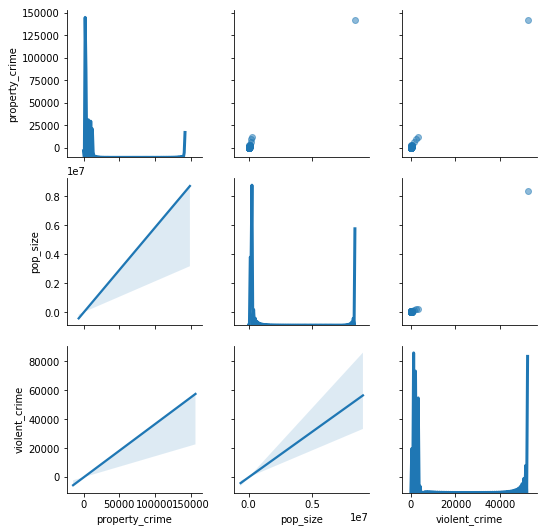

In [20]:
#sns.pairplot(df[['property_crime', 'pop_size', 'violent_crime']].dropna(how = 'any', axis = 0))

# Make a scatterplot Matrix.
g = sns.PairGrid(df[['property_crime', 'pop_size', 'violent_crime']].dropna(how = 'any', axis = 0), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()


### Feature Engineering: New York appears to be a distinct outlier, will remove now to see how it affects error/residual plot.

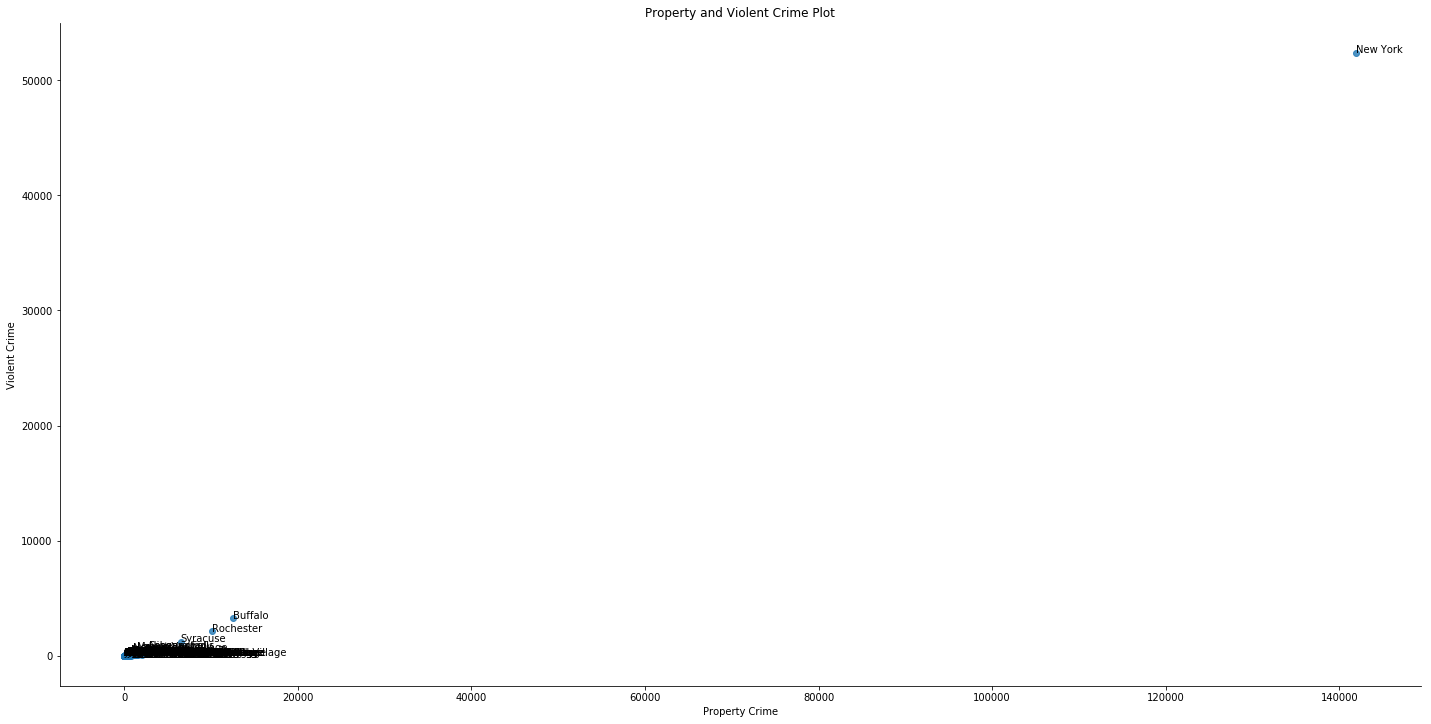

In [21]:
# Show outliers and label them

# Annotated scatter plot with no regression line (fit_reg=False)
# https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn
ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df['property_crime'], df['violent_crime'], df['city'], plt.gca()) 

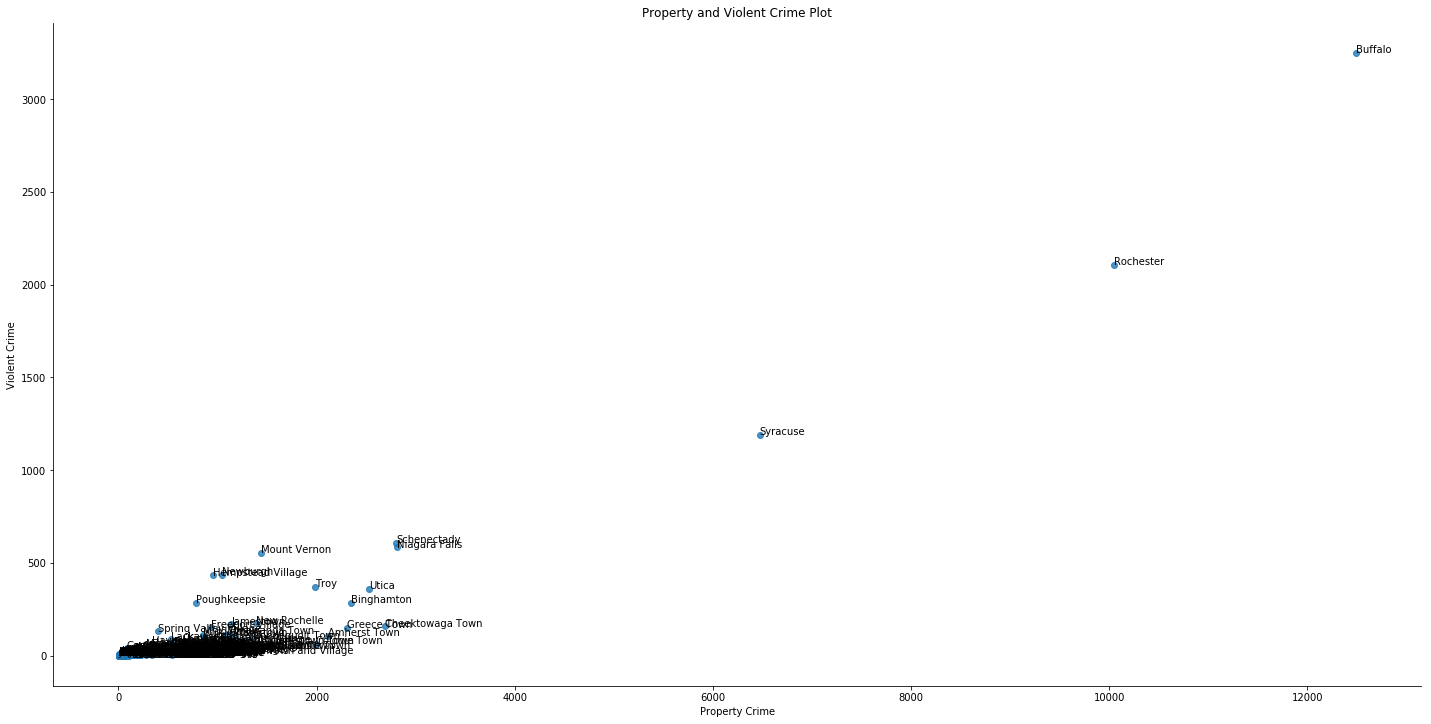

In [22]:
# Remove NY outlier

# create new df without outlier for city: New York
df_ny_removed = df[df['city'] != 'New York']

# show new annotated scatter plot without new york

ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df_ny_removed,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df_ny_removed['property_crime'], df_ny_removed['violent_crime'], df_ny_removed['city'], plt.gca()) 


### Feature Engineering: Now Buffalo, Rochester, Syracuse appear to be outliers.  But are they?

#### To determine statistical outliers and whether they should be removed from analysis, will define quartiles and interquartile range so that all data points (cities) that remain outside of this range can be removed.


In [23]:
# Quartiles and Interquartile Range (IQR)
q75, q25 = np.percentile(df['pop_size'].dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

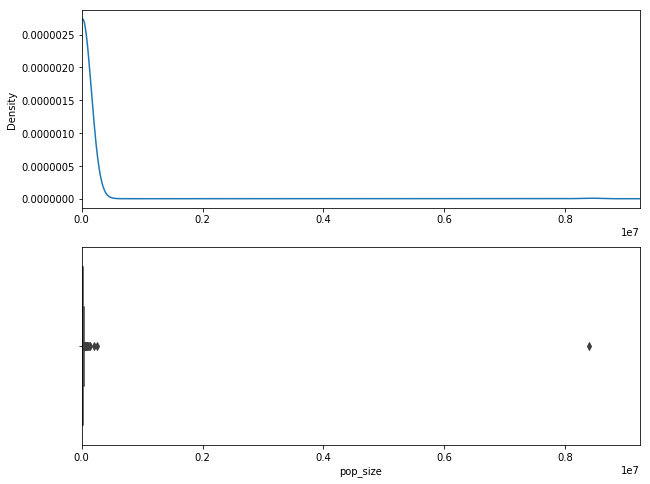

In [24]:
# Raw population distribution kde and boxplot
i = 'pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i].min(), df[i].max()*1.1)
sns.boxplot(x=df[i]);


In [25]:
# Do a log transform to normalize population size and create new feature called log_pop_size

# Remove any zeros (otherwise we get (-inf)
df.loc[df['pop_size'] == 0, 'pop_size'] = np.nan


# Drop NA
df.dropna(inplace=True)

# Log Transform
df['log_' + i] = np.log(df[i])

In [26]:

# Convert back to int (in cell above it gets converted to float)
df['pop_size'] = df['pop_size'].astype(int)

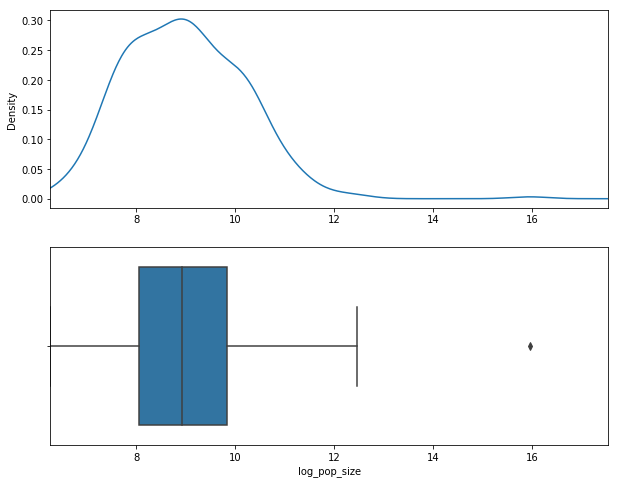

In [27]:
# plot log transformed population and boxplot to show effect on normality in log_pop_size
# (could also try other transformations and do a Shapiro test to quantify normality as compared to theoretical ideal)

i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
 
ax = df[i_log].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
sns.boxplot(x=df[i_log]);

In [28]:
# Get quartiles and interquartile range in log transformed population size
q75, q25 = np.percentile(df['log_pop_size'].dropna(), [75 ,25])
iqr = q75 - q25
 
min = q25 - (iqr*1.5)
max = q75 + (iqr*1.5)

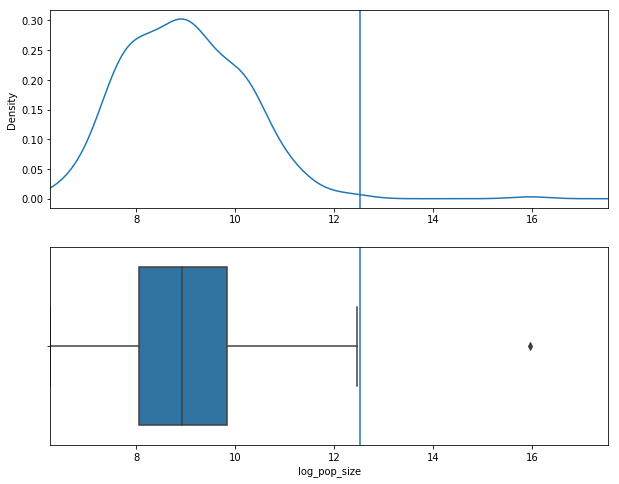

In [29]:
# Show outliers that fall outside of IQR * 1.5: only New York city is determined an outlier.
i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
 
ax = df[i_log].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
sns.boxplot(x=df[i_log])
plt.axvline(x=min)
plt.axvline(x=max);

In [30]:
# Define outlier in log transformed pop_size and create new variable called outlier

df['outlier'] = 0

# Convert to float to avoid data type conversion warnings
df['outlier'] = df['outlier'].astype(int)
 
df.loc[df[i_log] < min, 'outlier'] = 1
df.loc[df[i_log] > max, 'outlier'] = 1


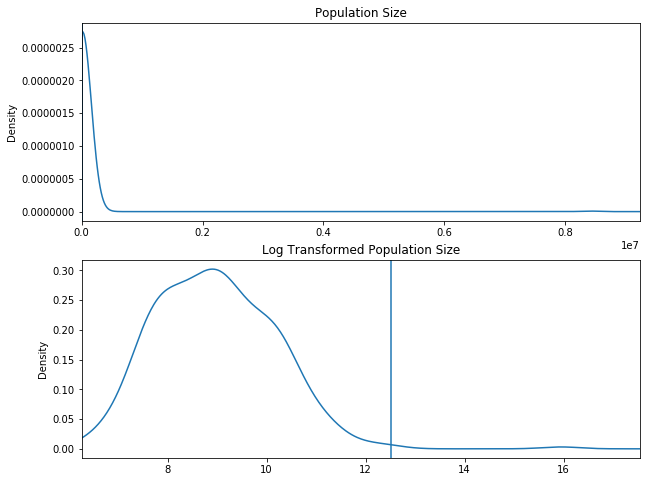

In [31]:
# Show differences in distribution of raw vs. log transformed population size data

i = 'pop_size'
i_log = 'log_pop_size'
 
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(df[i].min(), df[i].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
plt.title('Population Size')
 
ax = df[i].plot(kind='kde')
 
plt.subplot(212)
plt.xlim(df[i_log].min(), df[i_log].max()*1.1)
plt.axvline(x=min)
plt.axvline(x=max)
plt.title('Log Transformed Population Size')

ax = df[i_log].plot(kind='kde');

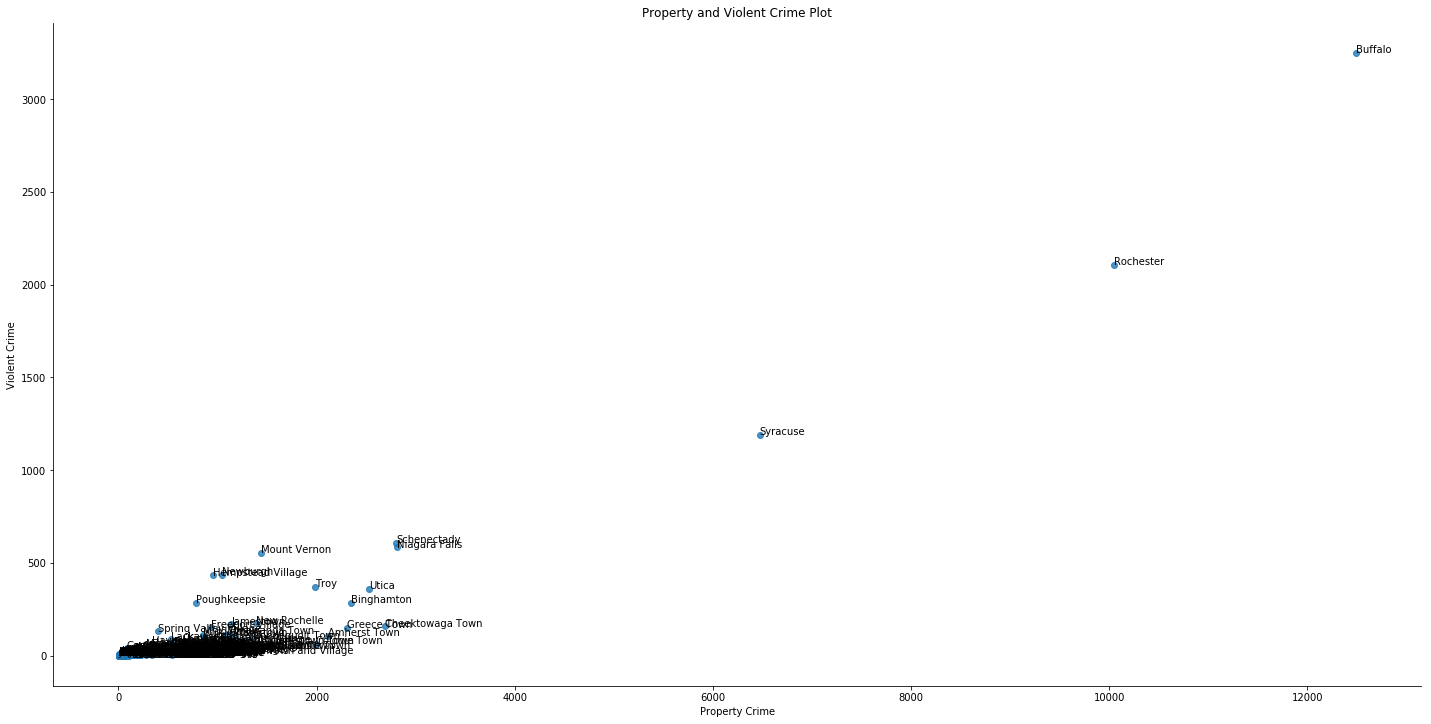

In [32]:
# create new df without outlier New York and plot property crime against violent crime
df_outliers_removed = df[df['outlier'] != 1].copy()


# show new annotated scatter plot without new york

ax = sns.lmplot('property_crime',
           'violent_crime',
           data=df_outliers_removed,
           fit_reg=False,
           height = 10,
           aspect =2 ) # size and dimension

plt.title('Property and Violent Crime Plot')
# Set x-axis label
plt.xlabel('Property Crime')
# Set y-axis label
plt.ylabel('Violent Crime')


def label_point(x, y, city, ax):
    a = pd.concat({'x': x, 'y': y, 'city': city}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['city']))

label_point(df_outliers_removed['property_crime'], df_outliers_removed['violent_crime'], df_outliers_removed['city'], plt.gca()) 


In [33]:
# Change in number of rows and columns
df_outliers_removed.shape

(334, 16)

## Recheck Linearity: Linearity of independent variables to dependent variable

#### This time linearity check includes all crimes subsumed by violent crime to look at linearity between property crime and murder/manslaughter, rape, aggravated assault, and robbery.

#### Population size appears to have strongest linear relationship independent variable with best confidence

#### After population size, independent variables aggravated assault, rape, and robbery appear to have strongest linear relationship with best confidence

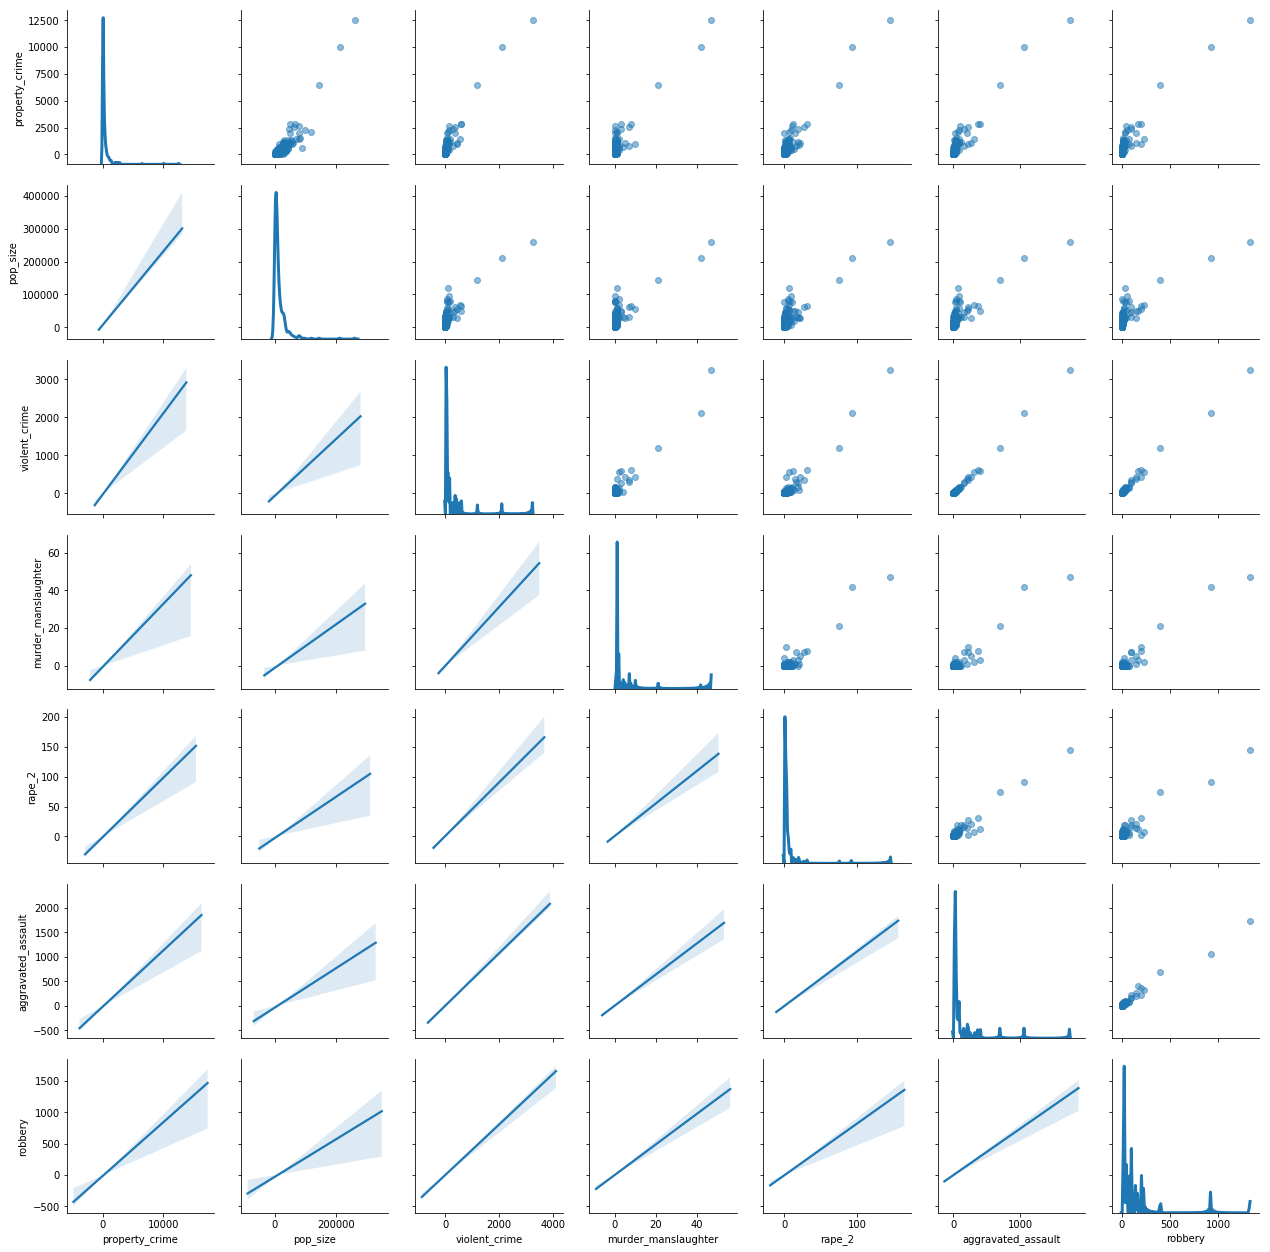

In [34]:
# Check out linearity between property crime and individual violent crimes now that new york outlier is removed
# Make a scatterplot Matrix.
g = sns.PairGrid(df_outliers_removed[['property_crime', 'pop_size', 'violent_crime', 'murder_manslaughter', 
                                'rape_2', 'aggravated_assault', 'robbery']].dropna(how = 'any', axis = 0), diag_sharey=False)

# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

### R-squared improved, but is still high at .965

### y intercept now negative after removing pop_size outliers, but since there are multiple independent variables having different effects and indication of strong multicolinearity in condition number, will do PCA to identify best components for analysis.

In [35]:
# requires import statsmodels.formula.api as smf

lm_2 = smf.ols(formula = "property_crime ~ pop_size + murder_manslaughter + aggravated_assault + rape_2 + robbery", data = df_outliers_removed).fit()
lm_2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          2.79e-237
Time:                        14:09:19   Log-Likelihood:                -2227.4
No. Observations:                 334   AIC:                             4467.
Df Residuals:                     328   BIC:                             4490.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -17.9310     13.713     -1.308      0.192     -44.907       9.045
pop_size                0.0162      0.001     21.835      0.000       0.015       0.018
murder_manslaughter     9.4950     13.152      0.722      0.471     -16.377      35.367
aggravated_assault      1.3640      0.676      2.016      0.045       0.033       2.695
rape_2                 33.1229      4.369      7.581      0.000      24.528      41.718
robbery                 0.9763      0.916      1.066      0.287      -0.826       2.778
==============================================================================
Omnibus:                       68.484   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              997.710
Skew:                           0.283   Prob(JB):                    2.24e-217
Kurtosis:                      11.448   Cond. No.                     3.87e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.87e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Will Use PCA to identify which components explain most of variance.

### One component explains 80.48% of variance.  Will identify variables in that component and use for analysis.

In [36]:
# PCA: reduce dimensionality and prevent multi-colinearity - I may have picked the wrong variables, so this will help me
# identify the right variables to use (can't include categorical variables - axis=1 because it's a city

# have to drop city because it's not numerical, drop depedent/target variable: property_crime
# drop pop_size (keep log_pop_size)
# drop categorical variables: murder_manslaughter and robbery
# drop outliers

df_no_city = df_outliers_removed.drop(['city', 'property_crime', 'log_pop_size'], axis=1).dropna()

X = StandardScaler().fit_transform(df_no_city)
sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA:\n',
    sklearn_pca.explained_variance_ratio_
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA:
 [0.80482732 0.10019881 0.05616384 0.02238086 0.00608812]


In [37]:
# Eigenvalues and eigenvector - try to find the line that best fits the data
# by minimizing the distance between the line and the data points and maximizing the variance explained by the data
# the numbers associated with final points for this line for this component
Y_sklearn[:, 0]

array([-4.10661766e-01, -7.42974359e-01, -9.49898793e-01,  2.98768615e+00,
       -4.81765803e-01, -1.18834638e-01, -9.34686992e-01, -7.39324877e-01,
       -9.77879957e-01, -9.38668337e-01,  1.41617337e+00, -7.65391600e-01,
       -6.79044232e-01, -6.90621421e-01,  9.61093335e-02, -5.60399748e-01,
       -5.04574969e-01, -1.31634755e-01,  3.97779210e+00, -9.62626156e-01,
       -6.71266702e-01, -9.67443605e-01, -9.38536109e-01, -9.45762441e-01,
       -7.60720655e-01, -9.51604363e-01, -8.86648761e-01,  9.35358634e-01,
       -3.82927492e-03, -8.62739786e-01, -9.68556876e-01,  4.06792048e+01,
       -9.04625892e-01, -9.20046543e-01, -9.18304153e-01, -4.07291276e-01,
       -3.76230266e-01, -8.76043893e-01, -7.93453110e-01, -6.90875186e-01,
       -9.76706074e-01, -3.13672532e-01, -9.41115445e-01, -8.67743101e-01,
       -9.73370731e-01, -7.56975061e-01, -9.17195702e-01, -7.59094879e-01,
       -9.37025089e-01,  3.09266530e+00, -8.78233363e-01, -8.79865904e-01,
       -2.11762843e-01,  

### PCA Component:

#### Aggravated Assault and Robbery violent crimes appear to explain the greatest level of variance in the model


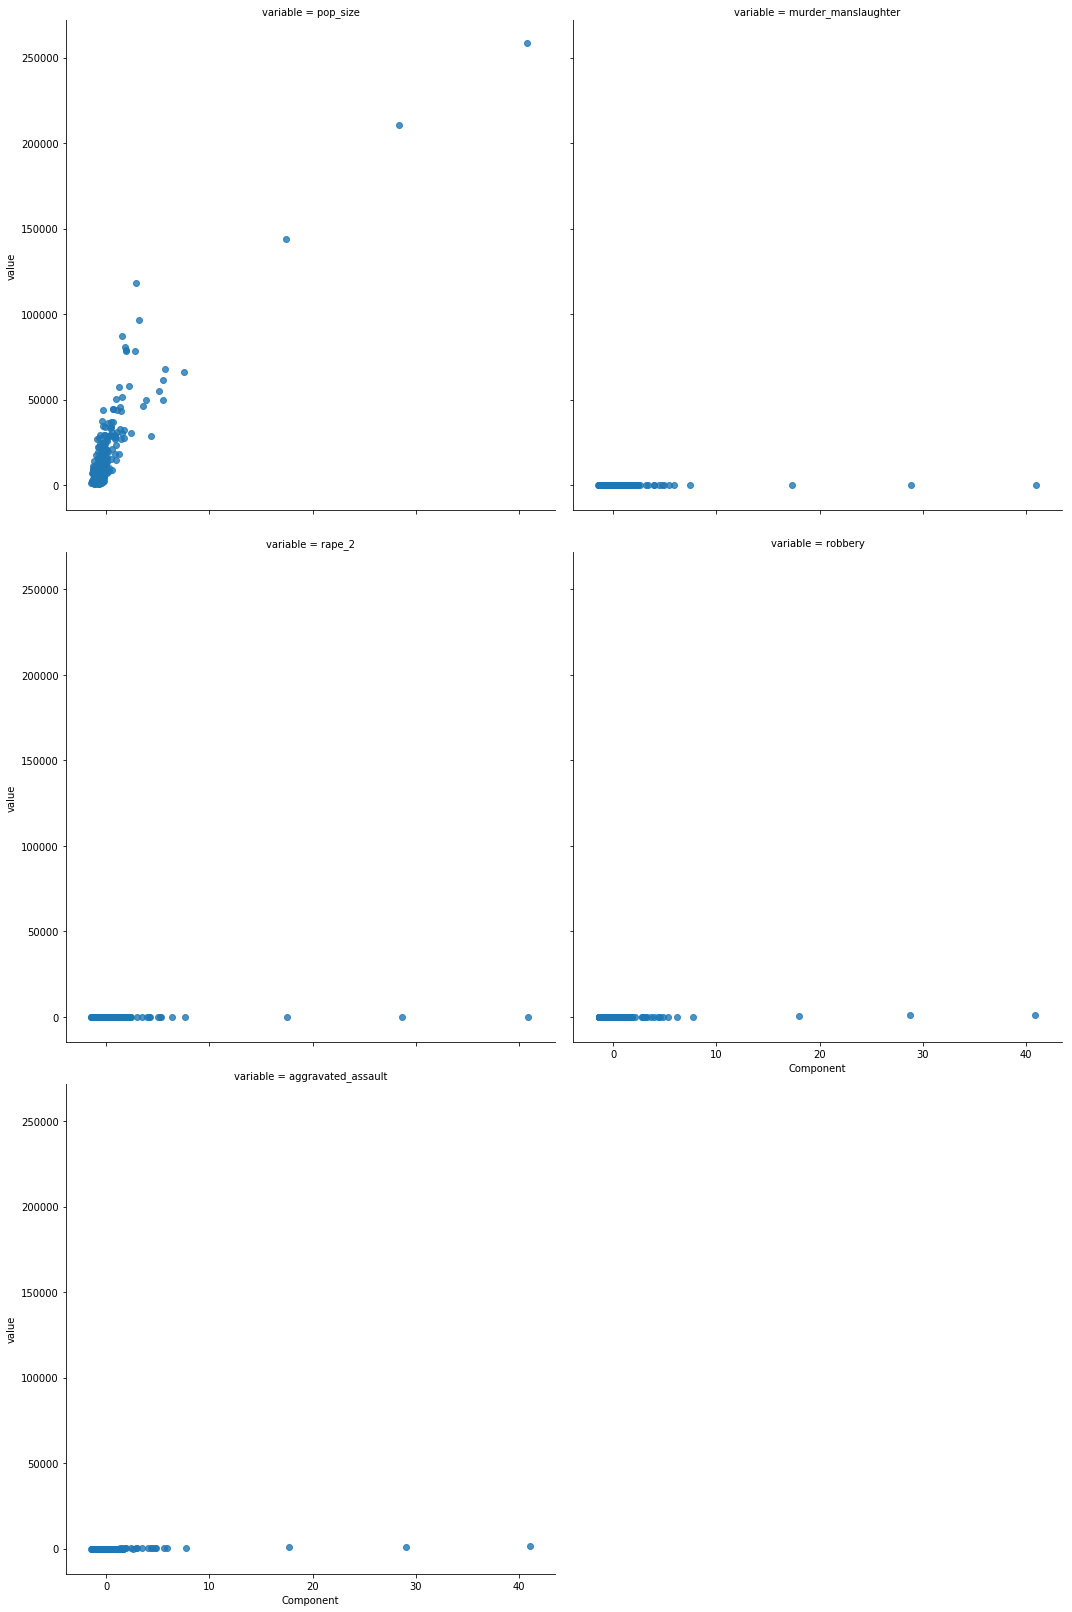

In [38]:
# DO OLS WITH most linear

# Identify what's in the components that's responsible for result:
# Remove first variable (property crime) because it is dependent
# Remove categorical variables, pop_size_squared, and arson_3 because types don't match

data_to_plot = df_no_city.drop(['violent_crime', 'murder_manslaughter_cat', 'robbery_cat', 
                                'burglary', 'larceny_theft', 'mv_theft',
                               'arson_3', 'outlier'], axis=1)
data_to_plot['Component'] = Y_sklearn[:,0]
data_to_plot = pd.melt(data_to_plot, id_vars='Component')

g = sns.FacetGrid(data_to_plot, col="variable", col_wrap=2, height=7.5, aspect=1)
g = g.map(
  sns.regplot,
  "Component",
  "value",
  x_jitter=.49,
  y_jitter=.49,
  fit_reg=False
)


plt.show()


### Check Normality of Errors in Residual Plot
#### Dependent variable: property_crime
#### Independent variables: robbery, and aggravated_assault

In [39]:
# Extract predicted values.

# Reset x and y for regression since removed outlier and it changed shape of df after setting x and y:

# Instantiate the model.
lin_regr = linear_model.LinearRegression()

# Fit model to data.
y_residual = pd.DataFrame(df_outliers_removed['property_crime'])
x_residual = pd.DataFrame(df_outliers_removed[['aggravated_assault', 'robbery']])

lin_regr.fit(x_residual, y_residual)

# Extract predicted and actual values.
predicted = lin_regr.predict(x_residual).ravel()
actual = df_outliers_removed['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted


/Users/evarubin/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


### Residual Error Plot indicates multivariate normality is an issue.

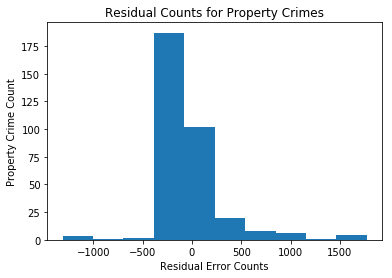

In [40]:
# Residual Error Plot
plt.hist(residual)
plt.title('Residual Counts for Property Crimes')
plt.xlabel('Residual Error Counts')
plt.ylabel('Property Crime Count')
plt.show()

### Regression

#### R-squared continues to be high even with reduced features. Overfit likely.
#### Condition number continues to be high, indicating continued likelihood of multicolinearity

In [41]:
lm_3 = smf.ols(formula = "property_crime ~ pop_size", data = df_outliers_removed).fit()
lm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1719.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):          2.56e-133
Time:                        14:09:47   Log-Likelihood:                -2485.4
No. Observations:                 334   AIC:                             4975.
Df Residuals:                     332   BIC:                             4982.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -199.3481     26.607     -7.492      0.000    -251.688    -147.008
pop_size       0.0373      0.001     41.459      0.000       0.036       0.039
==============================================================================
Omnibus:                       96.106   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4142.118
Skew:                           0.230   Prob(JB):                         0.00
Kurtosis:                      20.246   Cond. No.                     3.47e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Data is not linear as indicated by Error Residuals Probability Plot


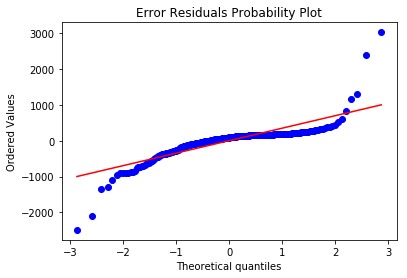

In [42]:
# Probability Plot to view normality (blue data should fit to red line of expected error)
stats.probplot(lm_3.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

### Data is heteroscedastic as indicated by Residual Error Plot

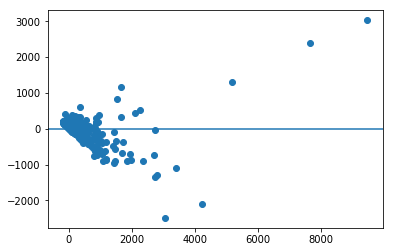

In [43]:
# Residual Error Plot
resid_3 = lm_3.resid
plt.axhline(y=0)
plt.scatter(lm_3.predict(), resid_3);

### Quanitify normality in Kolmogorov-Smirnov Test:

In [44]:
# KS test to quantify normality
# reject null hypothesis: residual error is drawn from "same population" as normally distributed population
#(theoretical norm in this case).  Error is not normally distributed.

print('Kolmogorov-Smirnov test:')
print(stats.kstest(lm_3.resid, 'norm'))

Kolmogorov-Smirnov test:
KstestResult(statistic=0.6391006085694875, pvalue=0.0)


In [45]:
# Fix non-normality
# https://stattrek.com/regression/linear-transformation.aspx?tutorial=ap

### Feature Engineering: Address normality of independent variable, robbery:

#### Log Transformation best fit and saved as new feature: log_robbery
#### Distribution remains skewed

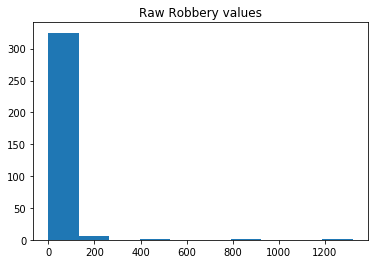

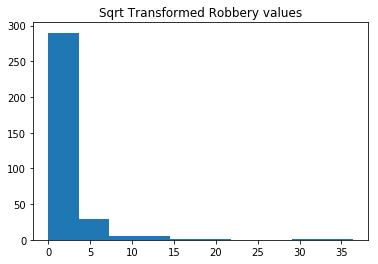

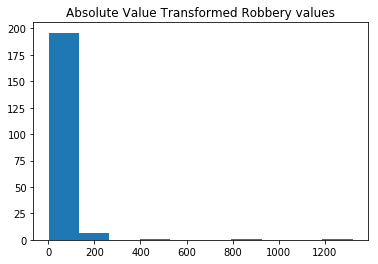

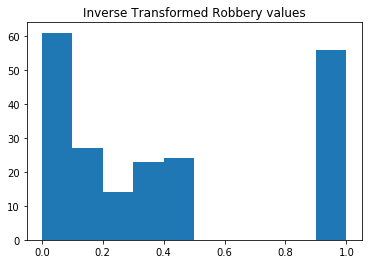

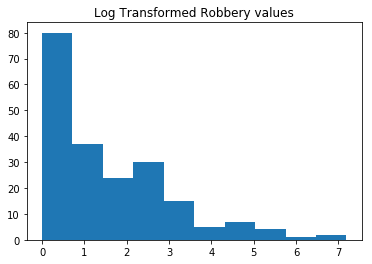

In [46]:
# Look at normality of distribution: robbery

# Sample data.
feature_robbery = df_outliers_removed['robbery']

# Plot the Raw Murder_Manslaughter Values.
plt.hist(feature_robbery)
plt.title('Raw Robbery values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_robbery = [math.sqrt(x) for x in feature_robbery]

# SQRT Murder_Manslaughter feature
plt.hist(sqrt_feature_robbery)
plt.title('Sqrt Transformed Robbery values')
plt.show()

# Create an Absolute Value Feature
df_outliers_removed_abs = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]
feature_robbery_abs = df_outliers_removed_abs['robbery']

abs_feature_robbery = [abs(x) for x in feature_robbery_abs]

# Absolute Value Robbery feature
plt.hist(abs_feature_robbery)
plt.title('Absolute Value Transformed Robbery values')
plt.show()


# Create an Inverse Feature
df_outliers_removed_inverse = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]
feature_robbery_inverse = df_outliers_removed_inverse['robbery']

inverse_feature_robbery = [1/x for x in feature_robbery_inverse]


# Inverse Robbery feature
plt.hist(inverse_feature_robbery)
plt.title('Inverse Transformed Robbery values')
plt.show()


# Create a Log feature using a non-linear transformation.
df_outliers_removed_log = df_outliers_removed.loc[(df_outliers_removed['robbery'] > 0)]


outcome_property_crime_log_2 = df_outliers_removed_log['property_crime']
feature_robbery_log = df_outliers_removed_log['robbery']

log_feature_robbery = [math.log(x) for x in feature_robbery_log]

# Log Robbery feature
plt.hist(log_feature_robbery)
plt.title('Log Transformed Robbery values')
plt.show()

In [47]:
# Get W, P-value
# W: test statistic - closest to 100 is most normal
# P-value: < .05 = NOT normal distribution

print('Shapiro Test - Robbery:')
print('Log: ', stats.shapiro(log_feature_robbery))
print('Inverse: ', stats.shapiro(inverse_feature_robbery))
print('Square Root: ', stats.shapiro(sqrt_feature_robbery))
print('Absolute Value: ', stats.shapiro(abs_feature_robbery))

print()

Shapiro Test - Robbery:
Log:  (0.8874810338020325, 2.928603540230945e-11)
Inverse:  (0.8033197522163391, 2.365435855205384e-15)
Square Root:  (0.5114853382110596, 2.4204414970211014e-29)
Absolute Value:  (0.20274782180786133, 1.0010542090743858e-28)



In [48]:
# Do a log transform to normalize robbery and create new feature called log_robbery

i_robbery = 'robbery'

# Remove any zeros (otherwise we get (-inf)
df_outliers_removed.loc[df_outliers_removed['robbery'] == 0, 'robbery'] = np.nan
 
# Drop NA
df_outliers_removed.dropna(inplace=True)
 
# Log Transform
df_outliers_removed['log_' + i_robbery] = np.log(df_outliers_removed[i_robbery])


### Feature Engineering: Address normality of independent variable, aggravated_assault:

#### Log Transformation best fit and saved as new feature: log_aggravated_assault
#### Distribution remains skewed

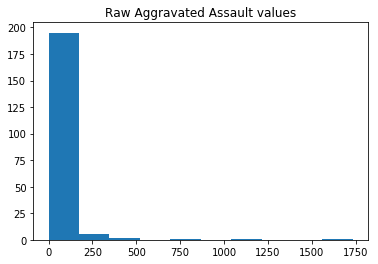

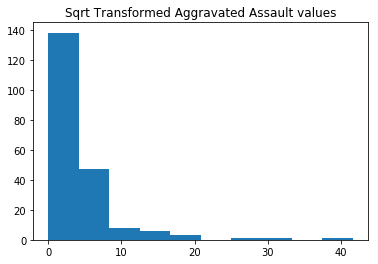

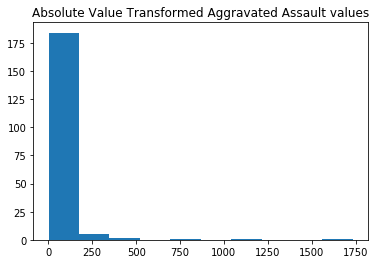

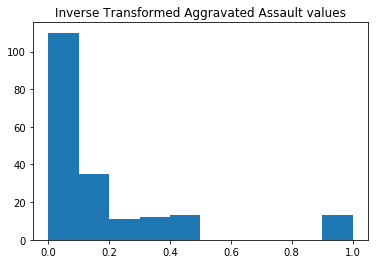

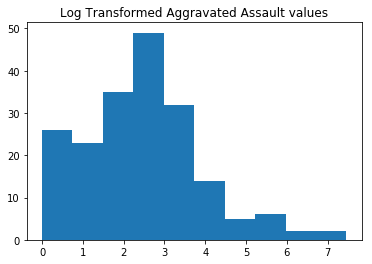

In [49]:
# Look at normality of distribution: relationship of independent variable property crime
# transformed to dependent variable aggravated_assault

# Sample data.
feature_aggravated_assault = df_outliers_removed['aggravated_assault']

# Plot the Raw Murder_Manslaughter Values.
plt.hist(feature_aggravated_assault)
plt.title('Raw Aggravated Assault values')
plt.show()

# Create a Square Root feature using a non-linear transformation.
sqrt_feature_aggravated_assault = [math.sqrt(x) for x in feature_aggravated_assault]

# SQRT aggravated_assault feature
plt.hist(sqrt_feature_aggravated_assault)
plt.title('Sqrt Transformed Aggravated Assault values')
plt.show()

# Create an Absolute Value Feature
df_outliers_removed_abs_aggravated_assault = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]
feature_aggravated_assault_abs = df_outliers_removed_abs_aggravated_assault['aggravated_assault']

abs_feature_aggravated_assault = [abs(x) for x in feature_aggravated_assault_abs]

# Absolute Value Robbery feature
plt.hist(abs_feature_aggravated_assault)
plt.title('Absolute Value Transformed Aggravated Assault values')
plt.show()


# Create an Inverse Feature
df_outliers_removed_inverse_aggravated_assault = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]
feature_aggravated_assault_inverse = df_outliers_removed_inverse_aggravated_assault['aggravated_assault']

inverse_feature_aggravated_assault = [1/x for x in feature_aggravated_assault_inverse]


# Inverse Robbery feature
plt.hist(inverse_feature_aggravated_assault)
plt.title('Inverse Transformed Aggravated Assault values')
plt.show()


# Create a Log feature using a non-linear transformation.
df_outliers_removed_log = df_outliers_removed.loc[(df_outliers_removed['aggravated_assault'] > 0)]


outcome_property_crime_log_3 = df_outliers_removed_log['property_crime']
feature_aggravated_assault_log = df_outliers_removed_log['aggravated_assault']

log_feature_aggravated_assault = [math.log(x) for x in feature_aggravated_assault_log]

# Log Robbery feature
plt.hist(log_feature_aggravated_assault)
plt.title('Log Transformed Aggravated Assault values')
plt.show()

In [50]:
# Get W, P-value
# W: test statistic - closest to 100 is most normal
# P-value: < .05 = NOT normal distribution

print('Shapiro Test - Aggravated Assault:')
print('Log: ', stats.shapiro(log_feature_aggravated_assault))
print('Inverse: ', stats.shapiro(inverse_feature_aggravated_assault))
print('Square Root: ', stats.shapiro(sqrt_feature_aggravated_assault))
print('Absolute Value: ', stats.shapiro(abs_feature_aggravated_assault))

print()

Shapiro Test - Aggravated Assault:
Log:  (0.9681671857833862, 0.00021726002159994096)
Inverse:  (0.6672518253326416, 2.558664797552289e-19)
Square Root:  (0.6127410531044006, 2.86980781561183e-21)
Absolute Value:  (0.2533971667289734, 2.4839901013748035e-27)



In [51]:
# Do a log transform to normalize aggravated_assault and create new feature called log_aggravated_assault

i_aggravated_assault = 'aggravated_assault'

# Remove any zeros (otherwise we get (-inf)
df_outliers_removed.loc[df_outliers_removed['aggravated_assault'] == 0, 'aggravated_assault'] = np.nan
 
# Drop NA
df_outliers_removed.dropna(inplace=True)
 
# Log Transform
df_outliers_removed['log_' + i_aggravated_assault] = np.log(df_outliers_removed[i_aggravated_assault])


### Ordinary Least Squares Linear Regression:

#### Best fit (R-squared = .804) appears with combination of log transformed features: population size, aggravated assault, and robbery

### R-Squared and y-intercept:

#### log_pop_size: .333 and -6490.15
#### log_aggravated_assault: .405 and -816.44
#### log_robbery: .453 and -342.5

#### pop_size + log_aggravated_assault + log_robbery: .804 and -311.93

#### log_pop_size + log_aggravated_assault: .428 and -3246
#### log_pop_size + log_robbery: .462 and -2040.12
#### log_aggravated_assault + log_robbery: .465 and -568.87

#### pop_size: .840 and -287.69
#### aggravated_assault .905 and 259.94
#### robbery: .891 and 325.86

#### pop_size + aggravated_assault + robbery: .956 and -6.01

#### pop_size + aggravated_assault: .956 and -12.88
#### pop_size + robbery: .949 and 11.84
#### aggravated_assault + robbery: .906 and 271.41



In [52]:
lm_4 = smf.ols(formula = "property_crime ~ robbery", data = df_outliers_removed).fit()
lm_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         property_crime   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     1566.
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           2.87e-94
Time:                        14:10:03   Log-Likelihood:                -1450.7
No. Observations:                 194   AIC:                             2905.
Df Residuals:                     192   BIC:                             2912.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    325.8583     31.729     10.270      0.000     263.277     388.440
robbery       10.0504      0.254     39.574      0.000       9.549      10.551
==============================================================================
Omnibus:                       84.772   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              401.359
Skew:                           1.639   Prob(JB):                     7.01e-88
Kurtosis:                       9.238   Cond. No.                         128.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Linear regression to prepare for cross validation:

# With original variables
df_regression = df_outliers_removed[['property_crime', 'robbery']]

# Instantiate the model.
regr = linear_model.LinearRegression()

# Fit our model to our data.  Use pd.DataFrame() around the column you're looking to convert
# Otherwise, you get errors related to df vs. pandas series
# https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

y_regr = df_outliers_removed['property_crime'].values.reshape(-1, 1)
x_regr = df_outliers_removed[['robbery']]

regr.fit(x_regr, y_regr)

# Display the attributes we calculated.

print('Coefficients: \n', regr.coef_)
print()
print('Y Intercept: \n', regr.intercept_)
print()

Coefficients: 
 [[10.05038358]]

Y Intercept: 
 [325.85832273]



### Cross Validation of regression: instability in R-squared values in 5 random selections of data

In [54]:
# Some variation among cross validation scores, but more consistent than pre-transformed variables
cross_val_scores = cross_val_score(regr, x_regr, y_regr, cv=5)
cross_val_scores


array([0.89250003, 0.15083066, 0.19805286, 0.96144169, 0.80160106])

### Error Residuals Probability Plot shows continued poor fit between expected error and actual error after log transformation of robbery and aggravated_assault in feature engineering

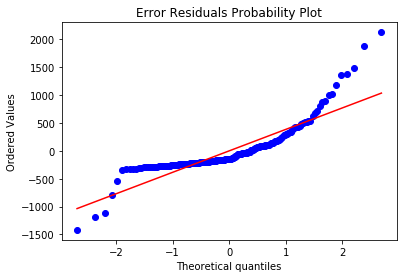

In [55]:
# Probability Plot to view normality (black data should fit to red line of expected error)
stats.probplot(lm_4.resid, plot= plt)
plt.title("Error Residuals Probability Plot");

### Residual Error Plot continues to show poor homoscedasticity after transformed dependent variable and identified best features (robbery and aggravated_assault) and transformed.

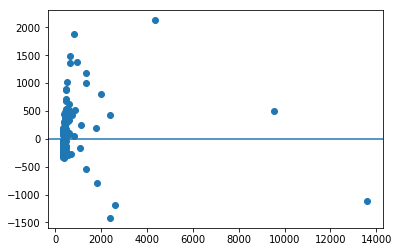

In [56]:
# Residual Error Plot
resid_4 = lm_4.resid
plt.axhline(y=0)
plt.scatter(lm_4.predict(), resid_4);

### Worsened statistic for KS test.  Error residual distribution continues to demonstrate poor fit against a normal distribution

In [57]:
# KS test to quantify normality
# reject null hypothesis: residual error is drawn from "same population" as normally distributed population
#(theoretical norm in this case).
# Error is not normally distributed, but much closer to normal than initial KS Test.
# Initial KstestResult(statistic=0.6391752534598999, pvalue=0.0)

print('Kolmogorov-Smirnov test:')
print(stats.kstest(lm_4.resid, 'norm'))

Kolmogorov-Smirnov test:
KstestResult(statistic=0.6443298969072165, pvalue=0.0)


In [58]:
# Check out multicolinearity in correlations between variables
# https://pythonprogramming.net/pandas-statistics-correlation-tables-how-to/
# df_outliers_removed[['log_pop_size', 'log_robbery', 'log_aggravated_assault']].corr()

corr = df_outliers_removed[['log_pop_size', 'log_robbery', 'log_aggravated_assault']].corr().stack()

corr = corr[corr.index.get_level_values(0) != corr.index.get_level_values(1)]
corr

log_pop_size            log_robbery              0.764
                        log_aggravated_assault   0.748
log_robbery             log_pop_size             0.764
                        log_aggravated_assault   0.861
log_aggravated_assault  log_pop_size             0.748
                        log_robbery              0.861
dtype: float64

### Review:

#### Linearity: unable to improve linearity through feature enginering

#### Multivariate Normality: feature engineering has some impact on normality of error, but not enough

#### Homoscedasticity: poor improvement with feature engineering

#### Low multicollinearity: concerns over multicolinearity between aggravated assault and robbery.

### Conclusions:

#### Prior to removing population outlier of NYC from data, pop_size was best predictor of property crime.

#### However, once pop_size outlier of NYC removed, OLS results that included pop_size or log_pop_size resulted in negative y-intercept. Given that the p-value is significant, could've concluded that linear regression model is not a good fit for this data.

#### Removed pop_size and log_pop_size from analysis and conducted PCA.  80% of variance in outcome explained by 4 violent crime variables.  Aggravated assault and robbery appeared to have most linear relationship with property crime.

#### Performed feature engineering to improve normality of independent variables to attempt to get better results. Re-ran OLS and re-checked linearity, multivariate normality, homoscedasticity multicolinearity.  Feature engineering transformations did not address issues present prior to transformations.

#### A linear regression model does not appear to be the best model for this data.


## Logistic Regression using rape_2

In [69]:

### Fit the model ###

# Declare predictors.
X_statsmod = df_outliers_removed[['robbery', 'aggravated_assault', 'murder_manslaughter', 'property_crime']].copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.

# 0 = no property crime; 1 = property crime
df_outliers_removed['property_crime_cat'] = np.where(df_outliers_removed['property_crime'] == 0, 0, 1)

df_outliers_removed['rape_cat'] = np.where(df_outliers_removed['rape_2'] == 0, 0, 1)


logit = sm.Logit(df_outliers_removed['rape_cat'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())




Optimization terminated successfully.
         Current function value: 0.460428
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               rape_cat   No. Observations:                  194
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                            4
Date:                Tue, 11 Dec 2018   Pseudo R-squ.:                  0.3074
Time:                        10:54:05   Log-Likelihood:                -89.323
converged:                       True   LL-Null:                       -128.96
                                        LLR p-value:                 2.471e-16
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                -0.0601      0.054     -1.113      0.266      -0.166       0.046
a

In [71]:
### Calculate Accuracy ###

# Calculate accuracy of logistic regression model. First, get probability that each row will be admitted.
pred_statsmod = result.predict(X_statsmod)

# Code rape occurrence as 1 if probability is greater than .5.
pred_y_statsmod = np.where(pred_statsmod < .5, 0, 1)

# Accuracy table.
table = pd.crosstab(df_outliers_removed['rape_cat'], pred_y_statsmod)

print('\n Accuracy by Rape occurrence status')
print(table)
print('\n Percentage accuracy')
print((table.iloc[0,0] + table.iloc[1,1]) / (table.sum().sum()))


 Accuracy by Rape occurrence status
col_0      0   1
rape_cat        
0         56  18
1         25  95

 Percentage accuracy
0.7783505154639175


## For purposes of logistic regression assignment, will choose an arbitrary marker to code property crime into categorical variable.

identify quantiles and mean pop size for each quantile
identify mean property crime for population sizes within each quantile

create new variable that assigns:
1 = property crime => 2 std above mean for the quantile in which that city exists
0 = property crime < 2 std below mean for the quantile in which that city exists

https://stackoverflow.com/questions/38356156/dataframe-add-column-whose-values-are-the-quantile-number-rank-of-an-existing-c

In [225]:
df_outliers_removed['pop_size_quantile'] = pd.qcut(df_outliers_removed['log_pop_size'], 5, labels=False)

pop_size_mean_by_quantile = df_outliers_removed.groupby(
      ['pop_size_quantile']).agg({'log_pop_size': ['mean']})

pop_size_mean_by_quantile

,log_pop_size
,mean
pop_size_quantile,
0,8.137
1,8.973
2,9.552
3,10.120
4,10.919


In [226]:
# Set variable to identify quartile range for each city by population size to compare property crime
# only against cities within same quartile

# Look at property crime by quartile
property_crime_mean_by_quantile = df_outliers_removed.groupby(
      ['pop_size_quantile']).agg({'property_crime': ['median', 'mean','std']})

print(property_crime_mean_by_quantile)
print()
print('There is a lot of variance even within population size quartiles.')

                  property_crime                  
                          median     mean      std
pop_size_quantile                                 
0                            101  115.744   71.990
1                            155  185.769  113.953
2                            314  334.395  197.152
3                            471  533.051  306.677
4                           1167 1895.179 2489.240

There is a lot of variance even within population size quartiles.


In [227]:
# Set variables that calculate quartile means
quantile_0_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 0),
                                                         'property_crime'].mean()

quantile_1_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 1),
                                                         'property_crime'].mean()

quantile_2_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 2),
                                                         'property_crime'].mean()

quantile_3_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 3),
                                                         'property_crime'].mean()

quantile_4_property_crime_mean = df_outliers_removed.loc[(df_outliers_removed['pop_size_quantile'] == 4),
                                                         'property_crime'].mean()


In [231]:
# Set variable to code all property crimes above the mean for each quartile range
property_crime_cat_1 = (

# quartile range 0
((df_outliers_removed['property_crime'] >= quantile_0_property_crime_mean) & 
                        (df_outliers_removed['property_crime'] < quantile_1_property_crime_mean)) |

# quartile range 1
((df_outliers_removed['property_crime'] >= quantile_1_property_crime_mean) 
& (df_outliers_removed['property_crime'] < quantile_2_property_crime_mean)) |

# quartile range 2
((df_outliers_removed['property_crime'] >= quantile_2_property_crime_mean) 
& (df_outliers_removed['property_crime'] < quantile_3_property_crime_mean)) |

# quartile range 3
((df_outliers_removed['property_crime'] >= quantile_3_property_crime_mean) 
& (df_outliers_removed['property_crime'] < quantile_4_property_crime_mean)) |

# quartile range 4
((df_outliers_removed['property_crime'] > quantile_4_property_crime_mean))
)

# Code 1 for any property crime above mean for the quartile in which that city exists
df_outliers_removed['property_crime_above_mean'] = np.where(
    property_crime_cat_1, 1, 0)


In [232]:

### Fit the model ###

# Declare predictors.
X_statsmod = df_outliers_removed[['robbery', 'aggravated_assault', 'murder_manslaughter']].copy()

# The Statsmodels formulation requires a column with constant value 1 that
# will act as the intercept.
X_statsmod['intercept'] = 1 

# Declare and fit the model.

logit = sm.Logit(df_outliers_removed['property_crime_above_mean'], X_statsmod)
result = logit.fit()

# Lots of information about the model and its coefficients, but the
# accuracy rate for predictions is missing.
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.284824
         Iterations 13
                               Logit Regression Results                              
Dep. Variable:     property_crime_above_mean   No. Observations:                  194
Model:                                 Logit   Df Residuals:                      190
Method:                                  MLE   Df Model:                            3
Date:                       Wed, 12 Dec 2018   Pseudo R-squ.:                  0.4477
Time:                               09:29:39   Log-Likelihood:                -55.256
converged:                              True   LL-Null:                       -100.05
                                               LLR p-value:                 2.682e-19
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
robbery                 0.4005   

In [189]:
# Recode strings to numeric.

# take out string related columns to avoid errors and all other added columns
df_outliers_removed_linear_no_city = df_outliers_removed.drop(columns=['city', 'violent_crime',
                                                                       'murder_manslaughter_cat', 'robbery_cat',
                                                                       'log_pop_size', 'outlier','log_robbery', 
                                                                       'log_aggravated_assault', 'property_crime_cat', 
                                                                       'rape_cat', 'pop_size_quantile',
                                                                       'property_crime_above_mean', 'robbery',
                                                                       'burglary', 'larceny_theft','mv_theft', 'arson_3'])

names = df_outliers_removed_linear_no_city.columns
#print(names)

# instantiate linear regression
df_outliers_removed_linear_regression = pd.DataFrame(preprocessing.scale(df_outliers_removed_linear_no_city), columns=names)

# Define the training and test sizes.
trainsize = int(df_outliers_removed_linear_regression.shape[0] / 2)
df_outliers_removed_linear_regression_test = df_outliers_removed_linear_regression.iloc[trainsize:, :].copy()
df_outliers_removed_linear_regression_train = df_outliers_removed_linear_regression.iloc[:trainsize, :].copy()

# Set up the linear regression model to predict defaults using all other variables as features.
linear_regr1 = linear_model.LinearRegression()
Y_train_linear_regression = df_outliers_removed_linear_regression_train['property_crime'].values.reshape(-1, 1)
X_train_linear_regression = df_outliers_removed_linear_regression_train.loc[:, ~(df_outliers_removed_linear_regression_train.columns).isin(['property_crime'])]
linear_regr1.fit(X_train_linear_regression, Y_train_linear_regression)

#print('y train: ', Y_train_linear_regression)
#print('x train: ')
#print(X_train_linear_regression)

print('\nR-squared simple model Linear Regression (Train):')
print(linear_regr1.score(X_train_linear_regression, Y_train_linear_regression))

#Store the parameter estimates.
origparams = np.append(linear_regr1.coef_, linear_regr1.intercept_)

# If I want to compare ridge regression against data with other potential features: 
# capture potential quadratic and cubic relationships #between the features

# combine two variables
#df_outliers_removed_linear_regression_train['balance_student'] = df_outliers_removed_linear_regression_train['balance'] * df_outliers_removed_linear_regression_train['student']
#df_outliers_removed_linear_regression_train['balance_default'] = df_outliers_removed_linear_regression_train['balance'] * df_outliers_removed_linear_regression_train['default']

# square root, quadratic, or cubic relationships
df_outliers_removed_linear_regression_train['property_crime_sqrt'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** .5
df_outliers_removed_linear_regression_train['property_crime_2'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** 2
df_outliers_removed_linear_regression_train['property_crime_3'] = (df_outliers_removed_linear_regression_train['property_crime'] + 100) ** 3

# Re-run the model with the new features.
lin_regr2 = linear_model.LinearRegression()
X_train_linear_regression2 = df_outliers_removed_linear_regression_train.loc[:, ~(df_outliers_removed_linear_regression_train.columns).isin(['property_crime'])]
lin_regr2.fit(X_train_linear_regression2, Y_train_linear_regression)
print('\nR-squared complex model (Test):')
print(lin_regr2.score(X_train_linear_regression2, Y_train_linear_regression))

# Store the new parameter estimates for the same features.
newparams = np.append(
    lin_regr2.coef_[0,0:(len(origparams)-1)],
    lin_regr2.intercept_)

print('\nParameter Estimates for the same predictors for the small model '
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)



R-squared simple model Linear Regression (Train):
0.9789171315858737

R-squared complex model (Test):
0.9999999999999986

Parameter Estimates for the same predictors for the small model and large model:
[[0.388 0.000]
 [-0.493 0.000]
 [0.175 0.000]
 [0.861 -0.000]
 [-0.002 -134.160]]


In [200]:
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train_linear_regression, Y_train_linear_regression)
print('\nRidge Regression Fit: ',ridgeregr.score(X_train_linear_regression, Y_train_linear_regression))

origparams = ridgeregr.coef_[0]

# Big Ridge Regression (added features of square root, quadratic, cubic)
ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train_linear_regression2, Y_train_linear_regression)
print('\nRidge Regression Big Fit: ', ridgeregrBig.score(X_train_linear_regression2, Y_train_linear_regression))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      ' and complex model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)



Ridge Regression Fit:  0.9717520763064155

Ridge Regression Big Fit:  0.9990795815957438

Parameter Estimates for the same predictors for the small model and complex model:
[[0.374 0.030]
 [0.087 -0.040]
 [0.277 -0.020]
 [0.234 -0.036]]


In [199]:
print('Accuracy Score:')
print('Ridge: ', ridgeregr.score(X_train_linear_regression, Y_train_linear_regression))
print('More complex ridge: ', ridgeregrBig.score(X_train_linear_regression2, Y_train_linear_regression))


Accuracy Score:
Ridge:  0.9717520763064155
More complex ridge:  0.9990795815957438


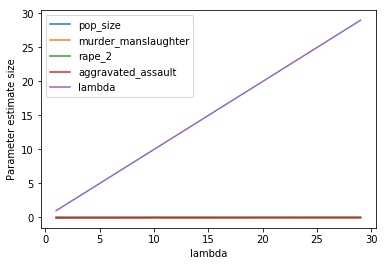

In [221]:
# Ridge Regression

# Store estimates.
estimates = np.append(ridgeregrBig.coef_, [10])

# Storing legend information.
labels = []

#Run the model for many alphas.
for lambd in range(1, 30, 2):
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train_linear_regression2, Y_train_linear_regression)
    estimates = np.row_stack((
        estimates,
        np.append(ridgeregrBig.coef_,[lambd])))

# Make the data pretty.
estimates_df = pd.DataFrame(
    estimates,
    columns=list(X_train_linear_regression2.columns) + ['lambda'])
estimates_df.sort_values(by='lambda', inplace=True, ascending=True)

# Leave out the 'property_crime' variables.
# It has very high values and throws off our plot's scale.
varstoplot = list(estimates_df.columns[:9,])
varstoplot.remove('property_crime_2')
varstoplot.remove('property_crime_3')
varstoplot.remove('property_crime_sqrt')
#varstoplot.remove('pop_size')
#varstoplot.remove('rape_2')
#varstoplot.remove('murder_manslaughter')

# Plot a line for each parameter.
for var in varstoplot:
    plt.plot(estimates_df['lambda'], estimates_df[var])
    labels.append(var)
plt.xlabel('lambda')
plt.ylabel('Parameter estimate size')
plt.legend(labels)
plt.show()

In [223]:
## Lasso Regression

# Small number of parameters.
lass = linear_model.Lasso(alpha=.35)
lassfit = lass.fit(X_train_linear_regression, Y_train_linear_regression)
print('R² for the model with few features:')
print(lass.score(X_train_linear_regression, Y_train_linear_regression))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)


# Large number of parameters.
lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train_linear_regression2, Y_train_linear_regression)
print('\nR² for the model with many features:')
print(lassBig.score(X_train_linear_regression2, Y_train_linear_regression))
origparams = np.append(lassBig.coef_, lassBig.intercept_)
print('\nParameter estimates for the model with many features:')
print(origparams)


# Check against the test

print(lass.score(X_test, Y_test))

print(lassBig.score(X_test2, Y_test))

R² for the model with few features:
0.8594312446662166

Parameter estimates for the model with few features:
[ 0.20962639  0.          0.0954927   0.34419148 -0.00536583]


Regularization parameter: Lasso
The  λλ  for lasso can var between 0 (no penalty, acts like OLS) and infinity. If  λλ  is too large, all parameters will be set to zero.

Create a plot below of how  R2R2  varies across different values of  λλ  for ridge and lasso regression. Use logic and code similar to the ridge regression demonstration above, and base your plot on the X_train2 feature set.

Do lasso and ridge yield the same  R2R2  for a given lambda value?

Submit your work and discuss the results with your mentor.

In [ ]:
# basically do the same thing with a loop that went through the different r-squared for lambda
# in the ridge regression section